# Mount to Drive
(This is in case you are working on google drive)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set directory to the folder here
%cd

# Import Libraries


In [ ]:
import os
import cv2
import shutil
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score, Metric
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Binarizer

random.seed(42)

# Prepare the data

In [ ]:
training_path = os.getcwd() + '/Data/train'
validation_path = os.getcwd() + '/Data/validation'
testing_other_path = os.getcwd() + '/Data/test_other'
testing_same_path = os.getcwd() + '/Data/test_same'

In [ ]:
data_generator = ImageDataGenerator()

train_it = data_generator.flow_from_directory(training_path,
                                              class_mode="binary",
                                              batch_size=32,
                                              target_size = (224, 224))

validation_it = data_generator.flow_from_directory(validation_path,
                                                   class_mode="binary",
                                                   batch_size=16,
                                                   target_size = (224, 224))

test_it = data_generator.flow_from_directory(testing_other_path,
                                             class_mode="binary",
                                             batch_size=16,
                                             target_size = (224, 224),)

test_primary_it = data_generator.flow_from_directory(testing_same_path,
                                             class_mode="binary",
                                             batch_size=16,
                                             target_size = (224, 224),)

batchX, batchY = train_it.next()
print("BatchX shape: {}, min: {}, max: {}".format(batchX.shape, batchX.min(), batchX.max()))
print("BatchY shape: {}".format(batchY.shape))

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
BatchX shape: (32, 224, 224, 3), min: 0.0, max: 255.0
BatchY shape: (32,)


# VGG19 Model Training

###### SET UP

In [ ]:
# Load pre-trained VGG19 model without including top layers
VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the ResNet50 model
for layer in VGG_model.layers:
    layer.trainable = False

# Setup classification metrics
precision_metric = Precision()
recall_metric = Recall()
f1 = F1Score()
auc_metric = AUC()

# Add custom layers
x = VGG_model.output
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Add final dense layer with 1 output neuron for binary classification
predictions = Dense(1, activation='sigmoid', name='predictions')(x)

# Define the model
model = Model(inputs=VGG_model.input, outputs=predictions)

# Define the optimizer with an initial learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', precision_metric, recall_metric, f1, auc_metric])

80134624/80134624 [==============================] - 0s 0us/step


###### TRAINING 2

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint(os.getcwd() + "Models/VGG19.h5", save_best_only=True, save_weights_only=True, save_freq=5)
]

# Fit the model with early stopping callback
history = model.fit_generator(
  train_it,
  validation_data=validation_it,
  epochs=40,
  steps_per_epoch=10,
  validation_steps=5,
  verbose=1,
  callbacks=callbacks
)

<ipython-input-9-eff162e84f26>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
 4/10 [===========>..................] - ETA: 9s - loss: 0.8622 - accuracy: 0.5000 - precision: 0.5286 - recall: 0.5441 - f1_score: 0.6939 - auc: 0.4804

 9/10 [==========================>...] - ETA: 4s - loss: 0.8552 - accuracy: 0.5208 - precision: 0.5337 - recall: 0.6333 - f1_score: 0.6849 - auc: 0.5114

10/10 [==============================] - 111s 10s/step - loss: 0.8577 - accuracy: 0.5188 - precision: 0.5266 - recall: 0.6037 - f1_score: 0.6777 - auc: 0.5093 - val_loss: 2.8258 - val_accuracy: 0.4875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6777 - val_auc: 0.5103 - lr: 0.0010
Epoch 2/40
 4/10 [===========>..................] - ETA: 25s - loss: 0.8517 - accuracy: 0.5234 - precision: 0.5208 - recall: 0.3968 - f1_score: 0.6597 - auc: 0.5133

 9/10 [==========================>...] - ETA: 6s - loss: 0.8259 - accuracy: 0.5382 - precision: 0.5849 - recall: 0.4106 - f1_score: 0.6879 - auc: 0.5699

10/10 [==============================] - 100s 11s/step - loss: 0.8291 - accuracy: 0.5344 - precision: 0.5680 - recall: 0.4277 - f1_score: 0.6831 - auc: 0.5640 - val_loss: 1.8455 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6667 - val_auc: 0.5325 - lr: 0.0010
Epoch 3/40
 4/10 [===========>..................] - ETA: 23s - loss: 0.8968 - accuracy: 0.5156 - precision: 0.4815 - recall: 0.6610 - f1_score: 0.6310 - auc: 0.5092

 9/10 [==========================>...] - ETA: 4s - loss: 0.8779 - accuracy: 0.5243 - precision: 0.4946 - recall: 0.6741 - f1_score: 0.6383 - auc: 0.5172

10/10 [==============================] - 74s 8s/step - loss: 0.8612 - accuracy: 0.5344 - precision: 0.5050 - recall: 0.6755 - f1_score: 0.6412 - auc: 0.5242 - val_loss: 1.1583 - val_accuracy: 0.4875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6777 - val_auc: 0.4728 - lr: 0.0010
Epoch 4/40
 4/10 [===========>..................] - ETA: 34s - loss: 0.7337 - accuracy: 0.5391 - precision: 0.5000 - recall: 0.3898 - f1_score: 0.6310 - auc: 0.5567

 9/10 [==========================>...] - ETA: 4s - loss: 0.7446 - accuracy: 0.5347 - precision: 0.5556 - recall: 0.3472 - f1_score: 0.6667 - auc: 0.6029

10/10 [==============================] - 85s 9s/step - loss: 0.7399 - accuracy: 0.5375 - precision: 0.5510 - recall: 0.3418 - f1_score: 0.6611 - auc: 0.6072 - val_loss: 1.1142 - val_accuracy: 0.5500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6207 - val_auc: 0.5325 - lr: 0.0010
Epoch 5/40
 4/10 [===========>..................] - ETA: 17s - loss: 0.7109 - accuracy: 0.6562 - precision: 0.7018 - recall: 0.5970 - f1_score: 0.6872 - auc: 0.6671

 9/10 [==========================>...] - ETA: 4s - loss: 0.7203 - accuracy: 0.6042 - precision: 0.6323 - recall: 0.6323 - f1_score: 0.6998 - auc: 0.6196 

10/10 [==============================] - 87s 9s/step - loss: 0.7236 - accuracy: 0.6000 - precision: 0.6271 - recall: 0.6416 - f1_score: 0.7018 - auc: 0.6180 - val_loss: 1.3807 - val_accuracy: 0.4375 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.7097 - val_auc: 0.5262 - lr: 0.0010
Epoch 6/40
 4/10 [===========>..................] - ETA: 17s - loss: 0.7242 - accuracy: 0.6641 - precision: 0.6265 - recall: 0.8125 - f1_score: 0.6667 - auc: 0.6658

 9/10 [==========================>...] - ETA: 2s - loss: 0.7357 - accuracy: 0.6250 - precision: 0.5824 - recall: 0.7279 - f1_score: 0.6415 - auc: 0.6455

10/10 [==============================] - 54s 5s/step - loss: 0.7470 - accuracy: 0.6187 - precision: 0.5882 - recall: 0.7097 - f1_score: 0.6526 - auc: 0.6353 - val_loss: 1.2793 - val_accuracy: 0.4875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6325 - val_auc: 0.4717 - lr: 0.0010
Epoch 7/40
 4/10 [===========>..................] - ETA: 18s - loss: 0.7301 - accuracy: 0.5938 - precision: 0.6078 - recall: 0.4921 - f1_score: 0.6597 - auc: 0.6352

 9/10 [==========================>...] - ETA: 2s - loss: 0.7012 - accuracy: 0.6042 - precision: 0.6029 - recall: 0.5775 - f1_score: 0.6605 - auc: 0.6455

10/10 [==============================] - 50s 5s/step - loss: 0.6983 - accuracy: 0.6062 - precision: 0.6129 - recall: 0.5901 - f1_score: 0.6694 - auc: 0.6464 - val_loss: 0.8685 - val_accuracy: 0.4875 - val_precision: 0.5000 - val_recall: 0.0488 - val_f1_score: 0.6777 - val_auc: 0.5410 - lr: 0.0010
Epoch 8/40
 4/10 [===========>..................] - ETA: 16s - loss: 0.6389 - accuracy: 0.6641 - precision: 0.6769 - recall: 0.6667 - f1_score: 0.6804 - auc: 0.7127

 9/10 [==========================>...] - ETA: 3s - loss: 0.6091 - accuracy: 0.6979 - precision: 0.6755 - recall: 0.7286 - f1_score: 0.6542 - auc: 0.7446

10/10 [==============================] - 53s 5s/step - loss: 0.6298 - accuracy: 0.6844 - precision: 0.6588 - recall: 0.7226 - f1_score: 0.6526 - auc: 0.7252 - val_loss: 0.8072 - val_accuracy: 0.4750 - val_precision: 0.5000 - val_recall: 0.0952 - val_f1_score: 0.6885 - val_auc: 0.6776 - lr: 0.0010
Epoch 9/40
 4/10 [===========>..................] - ETA: 11s - loss: 0.6136 - accuracy: 0.6406 - precision: 0.7077 - recall: 0.6301 - f1_score: 0.7264 - auc: 0.7323

 9/10 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5972 - precision: 0.6258 - recall: 0.6258 - f1_score: 0.6998 - auc: 0.6568

10/10 [==============================] - 41s 4s/step - loss: 0.7035 - accuracy: 0.5813 - precision: 0.6114 - recall: 0.6185 - f1_score: 0.7018 - auc: 0.6360 - val_loss: 0.9579 - val_accuracy: 0.5375 - val_precision: 0.6250 - val_recall: 0.1282 - val_f1_score: 0.6555 - val_auc: 0.6048 - lr: 0.0010
Epoch 10/40
 4/10 [===========>..................] - ETA: 11s - loss: 0.5659 - accuracy: 0.7109 - precision: 0.7097 - recall: 0.6984 - f1_score: 0.6597 - auc: 0.7774

 9/10 [==========================>...] - ETA: 1s - loss: 0.6131 - accuracy: 0.6632 - precision: 0.6667 - recall: 0.6712 - f1_score: 0.6728 - auc: 0.7324

10/10 [==============================] - 32s 3s/step - loss: 0.6130 - accuracy: 0.6625 - precision: 0.6667 - recall: 0.6829 - f1_score: 0.6777 - auc: 0.7284 - val_loss: 0.8213 - val_accuracy: 0.5750 - val_precision: 0.7368 - val_recall: 0.3256 - val_f1_score: 0.6992 - val_auc: 0.6691 - lr: 0.0010
Epoch 11/40
 4/10 [===========>..................] - ETA: 7s - loss: 0.6325 - accuracy: 0.6562 - precision: 0.6301 - recall: 0.7302 - f1_score: 0.6597 - auc: 0.7148

 9/10 [==========================>...] - ETA: 1s - loss: 0.6427 - accuracy: 0.6528 - precision: 0.6352 - recall: 0.7063 - f1_score: 0.6636 - auc: 0.7123

10/10 [==============================] - 41s 4s/step - loss: 0.6389 - accuracy: 0.6594 - precision: 0.6404 - recall: 0.7170 - f1_score: 0.6639 - auc: 0.7166 - val_loss: 0.5971 - val_accuracy: 0.6375 - val_precision: 0.6207 - val_recall: 0.5000 - val_f1_score: 0.6207 - val_auc: 0.7219 - lr: 0.0010
Epoch 12/40
 4/10 [===========>..................] - ETA: 12s - loss: 0.5808 - accuracy: 0.6953 - precision: 0.6500 - recall: 0.8254 - f1_score: 0.6597 - auc: 0.7774

 9/10 [==========================>...] - ETA: 1s - loss: 0.6195 - accuracy: 0.6528 - precision: 0.6500 - recall: 0.7027 - f1_score: 0.6789 - auc: 0.7275

10/10 [==============================] - 47s 4s/step - loss: 0.6486 - accuracy: 0.6438 - precision: 0.6573 - recall: 0.6882 - f1_score: 0.6939 - auc: 0.7090 - val_loss: 0.6103 - val_accuracy: 0.7250 - val_precision: 0.7727 - val_recall: 0.7391 - val_f1_score: 0.7302 - val_auc: 0.7417 - lr: 0.0010
Epoch 13/40
 4/10 [===========>..................] - ETA: 6s - loss: 0.6218 - accuracy: 0.6797 - precision: 0.6515 - recall: 0.7049 - f1_score: 0.6455 - auc: 0.7311

 9/10 [==========================>...] - ETA: 1s - loss: 0.6040 - accuracy: 0.6840 - precision: 0.6839 - recall: 0.7162 - f1_score: 0.6789 - auc: 0.7448

10/10 [==============================] - 22s 2s/step - loss: 0.5912 - accuracy: 0.7000 - precision: 0.7052 - recall: 0.7305 - f1_score: 0.6858 - auc: 0.7572 - val_loss: 0.6232 - val_accuracy: 0.6875 - val_precision: 0.7097 - val_recall: 0.5789 - val_f1_score: 0.6441 - val_auc: 0.7212 - lr: 0.0010
Epoch 14/40
 4/10 [===========>..................] - ETA: 9s - loss: 0.5911 - accuracy: 0.7344 - precision: 0.7215 - recall: 0.8261 - f1_score: 0.7005 - auc: 0.7773 

 9/10 [==========================>...] - ETA: 1s - loss: 0.5650 - accuracy: 0.7222 - precision: 0.6864 - recall: 0.8112 - f1_score: 0.6636 - auc: 0.7914

10/10 [==============================] - 20s 2s/step - loss: 0.5718 - accuracy: 0.7156 - precision: 0.6828 - recall: 0.7987 - f1_score: 0.6639 - auc: 0.7851 - val_loss: 0.6074 - val_accuracy: 0.6875 - val_precision: 0.7143 - val_recall: 0.6977 - val_f1_score: 0.6992 - val_auc: 0.7467 - lr: 0.0010
Epoch 15/40
 4/10 [===========>..................] - ETA: 7s - loss: 0.6355 - accuracy: 0.7031 - precision: 0.8261 - recall: 0.6867 - f1_score: 0.7867 - auc: 0.7783

 9/10 [==========================>...] - ETA: 1s - loss: 0.6299 - accuracy: 0.6771 - precision: 0.6959 - recall: 0.7437 - f1_score: 0.7143 - auc: 0.7360

10/10 [==============================] - 23s 2s/step - loss: 0.6276 - accuracy: 0.6812 - precision: 0.6911 - recall: 0.7543 - f1_score: 0.7071 - auc: 0.7379 - val_loss: 0.6246 - val_accuracy: 0.6625 - val_precision: 0.6383 - val_recall: 0.7500 - val_f1_score: 0.6667 - val_auc: 0.7153 - lr: 0.0010
Epoch 16/40
 4/10 [===========>..................] - ETA: 7s - loss: 0.7242 - accuracy: 0.6016 - precision: 0.4638 - recall: 0.6957 - f1_score: 0.5287 - auc: 0.6666

 9/10 [==========================>...] - ETA: 1s - loss: 0.6190 - accuracy: 0.6632 - precision: 0.5586 - recall: 0.7105 - f1_score: 0.5672 - auc: 0.7370

10/10 [==============================] - 20s 2s/step - loss: 0.6177 - accuracy: 0.6656 - precision: 0.5652 - recall: 0.7109 - f1_score: 0.5714 - auc: 0.7359 - val_loss: 0.7044 - val_accuracy: 0.6500 - val_precision: 0.7000 - val_recall: 0.5250 - val_f1_score: 0.6667 - val_auc: 0.6931 - lr: 0.0010
Epoch 17/40
 4/10 [===========>..................] - ETA: 8s - loss: 0.4901 - accuracy: 0.7656 - precision: 0.7451 - recall: 0.6909 - f1_score: 0.6011 - auc: 0.8330

 9/10 [==========================>...] - ETA: 1s - loss: 0.6290 - accuracy: 0.6875 - precision: 0.6930 - recall: 0.5896 - f1_score: 0.6351 - auc: 0.7406

10/10 [==============================] - 19s 2s/step - loss: 0.6176 - accuracy: 0.6875 - precision: 0.6935 - recall: 0.5811 - f1_score: 0.6325 - auc: 0.7460 - val_loss: 0.5682 - val_accuracy: 0.7250 - val_precision: 0.8378 - val_recall: 0.6596 - val_f1_score: 0.7402 - val_auc: 0.8201 - lr: 2.0000e-04
Epoch 18/40
 4/10 [===========>..................] - ETA: 4s - loss: 0.5132 - accuracy: 0.7969 - precision: 0.8269 - recall: 0.7167 - f1_score: 0.6383 - auc: 0.8510

 9/10 [==========================>...] - ETA: 0s - loss: 0.5360 - accuracy: 0.7569 - precision: 0.7563 - recall: 0.6870 - f1_score: 0.6253 - auc: 0.8131

10/10 [==============================] - 19s 2s/step - loss: 0.5286 - accuracy: 0.7500 - precision: 0.7481 - recall: 0.6759 - f1_score: 0.6237 - auc: 0.8176 - val_loss: 0.5567 - val_accuracy: 0.6875 - val_precision: 0.6486 - val_recall: 0.6667 - val_f1_score: 0.6207 - val_auc: 0.7778 - lr: 2.0000e-04
Epoch 19/40
 4/10 [===========>..................] - ETA: 4s - loss: 0.6052 - accuracy: 0.6641 - precision: 0.6744 - recall: 0.5000 - f1_score: 0.6237 - auc: 0.7511

 9/10 [==========================>...] - ETA: 0s - loss: 0.5914 - accuracy: 0.6701 - precision: 0.6900 - recall: 0.5188 - f1_score: 0.6318 - auc: 0.7639

10/10 [==============================] - 14s 1s/step - loss: 0.5980 - accuracy: 0.6656 - precision: 0.6726 - recall: 0.5205 - f1_score: 0.6266 - auc: 0.7556 - val_loss: 0.5348 - val_accuracy: 0.7500 - val_precision: 0.6957 - val_recall: 0.8421 - val_f1_score: 0.6441 - val_auc: 0.8336 - lr: 2.0000e-04
Epoch 20/40
 4/10 [===========>..................] - ETA: 5s - loss: 0.5457 - accuracy: 0.7422 - precision: 0.7377 - recall: 0.7258 - f1_score: 0.6526 - auc: 0.8101

 9/10 [==========================>...] - ETA: 1s - loss: 0.5334 - accuracy: 0.7604 - precision: 0.7463 - recall: 0.7407 - f1_score: 0.6383 - auc: 0.8153

10/10 [==============================] - 17s 2s/step - loss: 0.5333 - accuracy: 0.7688 - precision: 0.7671 - recall: 0.7368 - f1_score: 0.6441 - auc: 0.8178 - val_loss: 0.5141 - val_accuracy: 0.7875 - val_precision: 0.7255 - val_recall: 0.9250 - val_f1_score: 0.6667 - val_auc: 0.8359 - lr: 2.0000e-04
Epoch 21/40
 4/10 [===========>..................] - ETA: 5s - loss: 0.4726 - accuracy: 0.7969 - precision: 0.8667 - recall: 0.7429 - f1_score: 0.7071 - auc: 0.8702

 9/10 [==========================>...] - ETA: 1s - loss: 0.5578 - accuracy: 0.7431 - precision: 0.7652 - recall: 0.7014 - f1_score: 0.6667 - auc: 0.8041

10/10 [==============================] - 15s 2s/step - loss: 0.5457 - accuracy: 0.7531 - precision: 0.7703 - recall: 0.7170 - f1_score: 0.6639 - auc: 0.8128 - val_loss: 0.6481 - val_accuracy: 0.6750 - val_precision: 0.6200 - val_recall: 0.8158 - val_f1_score: 0.6441 - val_auc: 0.7155 - lr: 2.0000e-04
Epoch 22/40
 4/10 [===========>..................] - ETA: 8s - loss: 0.6496 - accuracy: 0.7109 - precision: 0.7846 - recall: 0.6892 - f1_score: 0.7327 - auc: 0.7555 

 9/10 [==========================>...] - ETA: 1s - loss: 0.6232 - accuracy: 0.6806 - precision: 0.6972 - recall: 0.6689 - f1_score: 0.6789 - auc: 0.7485

10/10 [==============================] - 16s 2s/step - loss: 0.6107 - accuracy: 0.6875 - precision: 0.7070 - recall: 0.6727 - f1_score: 0.6804 - auc: 0.7577 - val_loss: 0.6044 - val_accuracy: 0.6875 - val_precision: 0.6607 - val_recall: 0.8605 - val_f1_score: 0.6992 - val_auc: 0.7527 - lr: 2.0000e-04
Epoch 23/40
 4/10 [===========>..................] - ETA: 3s - loss: 0.5049 - accuracy: 0.7578 - precision: 0.7213 - recall: 0.7586 - f1_score: 0.6237 - auc: 0.8324

 9/10 [==========================>...] - ETA: 0s - loss: 0.5533 - accuracy: 0.7257 - precision: 0.6781 - recall: 0.7557 - f1_score: 0.6253 - auc: 0.7939

10/10 [==============================] - 17s 2s/step - loss: 0.5734 - accuracy: 0.7156 - precision: 0.6812 - recall: 0.7315 - f1_score: 0.6354 - auc: 0.7779 - val_loss: 0.6172 - val_accuracy: 0.6750 - val_precision: 0.6200 - val_recall: 0.8158 - val_f1_score: 0.6441 - val_auc: 0.7415 - lr: 2.0000e-04
Epoch 24/40
 4/10 [===========>..................] - ETA: 4s - loss: 0.5434 - accuracy: 0.7266 - precision: 0.7463 - recall: 0.7353 - f1_score: 0.6939 - auc: 0.8140

 9/10 [==========================>...] - ETA: 0s - loss: 0.5574 - accuracy: 0.7326 - precision: 0.7603 - recall: 0.7255 - f1_score: 0.6939 - auc: 0.8011

10/10 [==============================] - 13s 1s/step - loss: 0.5698 - accuracy: 0.7281 - precision: 0.7407 - recall: 0.7273 - f1_score: 0.6804 - auc: 0.7910 - val_loss: 0.5369 - val_accuracy: 0.7375 - val_precision: 0.6458 - val_recall: 0.8857 - val_f1_score: 0.6087 - val_auc: 0.8502 - lr: 2.0000e-04
Epoch 25/40
 4/10 [===========>..................] - ETA: 4s - loss: 0.5200 - accuracy: 0.7344 - precision: 0.7667 - recall: 0.6970 - f1_score: 0.6804 - auc: 0.8247

 9/10 [==========================>...] - ETA: 0s - loss: 0.5452 - accuracy: 0.7257 - precision: 0.7241 - recall: 0.7292 - f1_score: 0.6667 - auc: 0.7972

10/10 [==============================] - 10s 975ms/step - loss: 0.5567 - accuracy: 0.7219 - precision: 0.7256 - recall: 0.7301 - f1_score: 0.6749 - auc: 0.7897 - val_loss: 0.5378 - val_accuracy: 0.7750 - val_precision: 0.7391 - val_recall: 0.8500 - val_f1_score: 0.6667 - val_auc: 0.8212 - lr: 2.0000e-04
Epoch 26/40
 4/10 [===========>..................] - ETA: 4s - loss: 0.5871 - accuracy: 0.7266 - precision: 0.7656 - recall: 0.7101 - f1_score: 0.7005 - auc: 0.7686

 9/10 [==========================>...] - ETA: 0s - loss: 0.5941 - accuracy: 0.7222 - precision: 0.7415 - recall: 0.7219 - f1_score: 0.6879 - auc: 0.7727

10/10 [==============================] - 9s 929ms/step - loss: 0.5965 - accuracy: 0.7219 - precision: 0.7394 - recall: 0.7262 - f1_score: 0.6885 - auc: 0.7742 - val_loss: 0.5377 - val_accuracy: 0.7625 - val_precision: 0.6458 - val_recall: 0.9394 - val_f1_score: 0.5841 - val_auc: 0.8572 - lr: 4.0000e-05
Epoch 27/40
 4/10 [===========>..................] - ETA: 3s - loss: 0.5991 - accuracy: 0.7344 - precision: 0.6970 - recall: 0.7667 - f1_score: 0.6383 - auc: 0.7763

 9/10 [==========================>...] - ETA: 0s - loss: 0.5578 - accuracy: 0.7500 - precision: 0.7687 - recall: 0.7483 - f1_score: 0.6879 - auc: 0.8035

10/10 [==============================] - 12s 1s/step - loss: 0.5470 - accuracy: 0.7406 - precision: 0.7333 - recall: 0.7563 - f1_score: 0.6667 - auc: 0.8094 - val_loss: 0.5743 - val_accuracy: 0.7125 - val_precision: 0.6364 - val_recall: 0.9211 - val_f1_score: 0.6441 - val_auc: 0.8133 - lr: 4.0000e-05
Epoch 28/40
 4/10 [===========>..................] - ETA: 5s - loss: 0.5850 - accuracy: 0.6953 - precision: 0.7391 - recall: 0.7083 - f1_score: 0.7200 - auc: 0.7568

 9/10 [==========================>...] - ETA: 0s - loss: 0.5789 - accuracy: 0.7049 - precision: 0.7133 - recall: 0.7181 - f1_score: 0.6819 - auc: 0.7669

10/10 [==============================] - 9s 984ms/step - loss: 0.5636 - accuracy: 0.7219 - precision: 0.7202 - recall: 0.7423 - f1_score: 0.6749 - auc: 0.7822 - val_loss: 0.5435 - val_accuracy: 0.7250 - val_precision: 0.6604 - val_recall: 0.8974 - val_f1_score: 0.6555 - val_auc: 0.8299 - lr: 4.0000e-05


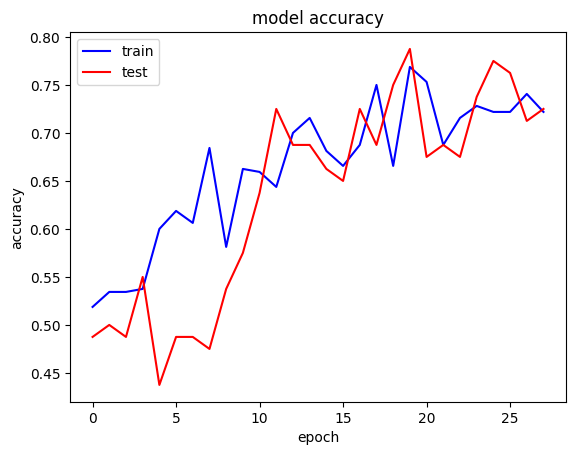

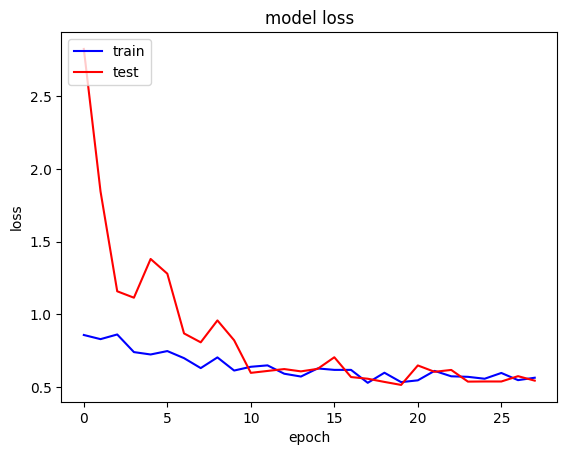

In [ ]:
# Plot the model's training and validation accuracy
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the model's training and validation loss
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###### TESTING (Other)

In [ ]:
model.evaluate(test_it, batch_size=5)

25/25 [==============================] - 113s 5s/step - loss: 0.7918 - accuracy: 0.4950 - precision: 0.4968 - recall: 0.7700 - f1_score: 0.6667 - auc: 0.5121


[0.7917998433113098,
 0.4950000047683716,
 0.49677419662475586,
 0.7699999809265137,
 array([0.6666667], dtype=float32),
 0.5121124982833862]

In [ ]:
y_pred = model.predict(test_it, batch_size=5)

25/25 [==============================] - 3s 107ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Binarizer

# Convert y_pred to binary values
binarizer = Binarizer(threshold=0.5)
y_pred_binary = binarizer.fit_transform(y_pred)
test_Y = test_it.labels
conf_matrix = confusion_matrix(test_Y, y_pred_binary)

print("Confusion Matrix: ")
print(conf_matrix)

Confusion Matrix: 
[[ 46 154]
 [ 44 156]]


###### TESTING (Same)

In [ ]:
model.evaluate(test_primary_it, batch_size=5)

50/50 [==============================] - 290s 6s/step - loss: 0.5904 - accuracy: 0.6675 - precision: 0.6419 - recall: 0.7575 - f1_score: 0.6667 - auc: 0.7542


[0.5904176831245422,
 0.6675000190734863,
 0.6419491767883301,
 0.7574999928474426,
 array([0.6666667], dtype=float32),
 0.7541905641555786]

In [ ]:
y_primary_pred = model.predict(test_primary_it, batch_size=5)

50/50 [==============================] - 10s 193ms/step


In [ ]:
# Convert y_primary_pred to binary values
y_primary_pred_binary = binarizer.fit_transform(y_primary_pred)
test_primary_Y = test_primary_it.labels
conf_matrix_primary = confusion_matrix(test_primary_Y, y_primary_pred_binary)

print("Confusion Matrix: ")
print(conf_matrix_primary)

Confusion Matrix: 
[[175 225]
 [153 247]]
